In [51]:
from pathlib import Path
from functools import reduce
import os
from matplotlib import pyplot as plt
import pandas as pd
from typing import Union, Tuple, List, Dict
import csv
import numpy as np
import seaborn as sns

In [52]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [201]:
# SYSTEM = 'sockshop'
SYSTEM = 'trainticket'
AD_DATA_FOLDER = Path(f"../AD/results/{SYSTEM}")
RCA_DATA_FOLDER = Path(f"../RCA/results/{SYSTEM}")
GT_FOLDER = Path(f"../AD/ground_truth.csv")
RESULTS_FOLDER = "statistics.csv"

AD_MODELS = ["BIRCH","iforest", "svm", "lof", "knn"]
AD_METRICS = ['Precision', 'Recall', 'F-Score']
RCA_MODELS = ['rcd', 'circa', 'MicroRCA', 'causalRCA']
RCA_METRICS = ['level_1', 'level_2', 'level_3']

SOCKSHOP_SERVICES = ['front-end', 'orders', 'carts', 'shipping', 'catalogue', 'payment', 'user']
TRAINTICKET_SERVICES= [
    'rabbitmq', 'redis', 'ts-ui-dashboard', 'ts-auth-service', 'ts-auth-mongo',
    'ts-user-service', 'ts-user-mongo', 'ts-verification-code-service', 'ts-account-mongo',
    'ts-route-service', 'ts-route-mongo', 'ts-contacts-service', 'ts-contacts-mongo',
    'ts-order-service', 'ts-order-mongo', 'ts-order-other-service', 'ts-order-other-mongo',
    'ts-config-service', 'ts-config-mongo', 'ts-station-service', 'ts-station-mongo',
    'ts-train-service', 'ts-train-mongo', 'ts-travel-service', 'ts-travel-mongo',
    'ts-travel2-service', 'ts-travel2-mongo', 'ts-preserve-service', 'ts-preserve-other-service',
    'ts-basic-service', 'ts-ticketinfo-service', 'ts-price-service', 'ts-price-mongo',
    'ts-notification-service', 'ts-security-service', 'ts-security-mongo',
    'ts-inside-payment-service', 'ts-inside-payment-mongo', 'ts-execute-service',
    'ts-payment-service', 'ts-payment-mongo', 'ts-rebook-service', 'ts-rebook-mongo',
    'ts-cancel-service', 'ts-assurance-service', 'ts-assurance-mongo', 'ts-seat-service',
    'ts-travel-plan-service', 'ts-ticket-office-service', 'ts-ticket-office-mongo',
    'ts-news-service', 'ts-news-mongo', 'ts-voucher-mysql', 'ts-voucher-service',
    'ts-food-map-service', 'ts-food-map-mongo', 'ts-route-plan-service', 'ts-food-service',
    'ts-consign-service', 'ts-consign-mongo', 'ts-consign-price-service', 'ts-consign-price-mongo',
    'ts-food-mongo', 'ts-admin-basic-info-service', 'ts-admin-order-service',
    'ts-admin-route-service', 'ts-admin-travel-service', 'ts-admin-user-service', 'ts-avatar-service'
]
SYSTEM_SERVICES = {'sockshop' : SOCKSHOP_SERVICES, 'trainticket' : TRAINTICKET_SERVICES}
DESCRIPTIVE_STATISTICS_FOLDER = Path(f"Descriptive statistics")

In [54]:
# retrieve the all folder names within specified directory
def get_folder_names(directory):
  folder_names = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
  return folder_names

In [5]:
def align_timeseries(gt_df, alg_df):
    # Ensure time alignment between ground truth and algorithm results
    return gt_df.set_index('time').reindex(alg_df['time']).reset_index()

In [6]:
def get_energy_anomaly_gt_ranges(scenario, service, user, alg_df):
    # Load the ground truth file
    gt_df = pd.read_csv(GT_FOLDER)

    # Filter the ground truth for the specific scenario, service, and user
    filtered_gt_df = gt_df[
        (gt_df['scenario'] == scenario) & 
        (gt_df['service'] == service) & 
        (gt_df['users'] == int(user))
    ]

    # Align the ground truth with the algorithm results by time
    aligned_gt_df = align_timeseries(filtered_gt_df, alg_df)

    # Initialize the structure for storing normal and anomalous segments
    gt_energy_metrics = {
        "normal_segments": {},
        "anomalous_segments": {}
    }

    # Process each relevant column in the aligned ground truth DataFrame
    for col in aligned_gt_df.columns:
        if not col.endswith("_Anomaly"):
            continue
        gt_energy_metrics["normal_segments"][col] = []
        gt_energy_metrics["anomalous_segments"][col] = []

        normal_start = None
        anomalous_start = None

        for index, value in aligned_gt_df[col].items():
            if value == 0:
                if normal_start is None:
                    normal_start = index
                else:
                    continue

                if anomalous_start is not None:
                    gt_energy_metrics["anomalous_segments"][col].append((anomalous_start, index - 1))
                    anomalous_start = None

            if value == 1:
                if anomalous_start is None:
                    anomalous_start = index
                else:
                    continue

                if normal_start is not None:
                    gt_energy_metrics["normal_segments"][col].append((normal_start, index - 1))
                    normal_start = None

        if normal_start is not None:
            gt_energy_metrics["normal_segments"][col].append((normal_start, len(aligned_gt_df[col])))
        elif anomalous_start is not None:
            gt_energy_metrics["anomalous_segments"][col].append((anomalous_start, len(aligned_gt_df[col])))

    return gt_energy_metrics


In [16]:
def generate_model_stats(results_path, gt_ranges, ad_results):
  # Create new directory if they do not exist
  directory = os.path.dirname(results_path)
  if not os.path.exists(directory):
      os.makedirs(directory)
  print(results_path)

  # Save data to a csv file
  with open(results_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    header = ["service_name", "true_positives", "false_positives", "false_negatives", "true_negatives"]
    writer.writerow(header)

    for col in ad_results.columns:
      if not col.endswith("_Anomaly"):
        continue

      true_positives = 0
      false_positives = 0
      false_negatives = 0
      total_points = len(ad_results[col])
      
      col_service = col.split("_")[0]
      gt_col = col_service + "_energy_Anomaly"
      
      # Debugging: Ensure column names match
      if gt_col not in gt_ranges["normal_segments"]:
          print(f"Warning: {gt_col} not found in ground truth data.")
          continue
      
      ad_metric_col = ad_results[col]
      
      for normal_range in gt_ranges["normal_segments"][gt_col]:
        range_start = normal_range[0]
        range_end = normal_range[1] + 1
        ad_range_values = ad_metric_col[range_start:range_end]


        # if one value within the range is marked as an anomaly then we consider it as a false positive
        if not ad_range_values.all() == 0:
          false_positives += 1

      for anomalous_range in gt_ranges["anomalous_segments"][gt_col]:
        range_start = anomalous_range[0]
        range_end = anomalous_range [1] + 1
        ad_range_values = ad_metric_col[range_start:range_end]

        if ad_range_values.any() == 1:
          true_positives += 1
        else:
          false_negatives += 1

      # Calculate TN
      true_negatives = total_points - (true_positives + false_positives + false_negatives)

      data_row = [col, true_positives, false_positives, false_negatives, true_negatives]
      writer.writerow(data_row)



In [46]:
def calculate_precision(tp, fp):
  if (tp + fp) == 0:
    return 0
  return round(tp / (tp + fp),3)


def calculate_recall(tp, fn):
  if (tp + fn) == 0:
    return 0
  return round(tp / (tp + fn),3)


def calculate_fscore(precision, recall):
  if precision + recall == 0:
    return 0
  fscore = 2 * ((precision * recall) / (precision + recall))

  return round(fscore,3)

def calculate_accuracy(tp, fp, fn, tn):
  total = tp + fp + fn
  if total == 0:
      return 0
  return round((tp) / total, 3)

In [18]:
def generate_performance_metrics(results_folder):
  # Create new directory if they do not exist
  if not os.path.exists(results_folder):
      os.makedirs(results_folder)

  # Get a list of CSV file paths
  csv_files = [os.path.join(results_folder, file) for file in os.listdir(results_folder) if file.endswith('.csv')]
 
  for file in csv_files:
    if not 'statistics' in file:
      continue
    model = file.split('\\')[-1].split('_')[0] 
    if not model in AD_MODELS:
      continue
    df = pd.read_csv(file)
    for i in range(0,len(df)):
      tp = df.loc[i, 'true_positives']
      fp = df.loc[i, 'false_positives']
      fn = df.loc[i, 'false_negatives']
      tn = df.loc[i, 'true_negatives']

      df.loc[i, 'precision'] = calculate_precision(tp, fp)
      df.loc[i, 'recall'] = calculate_recall(tp, fn)
      df.loc[i, 'f1score'] = calculate_fscore(df.loc[i, 'precision'], df.loc[i, 'recall'])
      df.loc[i, 'accuracy'] = calculate_accuracy(tp, fp, fn, tn)

    df.to_csv(file, index=False)

In [10]:
def get_stats_ad(trial_folder, scenario, service, user):
    for ad_model in AD_MODELS:
        ad_file = os.path.join(trial_folder, f'{ad_model}_results.csv')
        ad_results = pd.read_csv(ad_file)

        # Pass the scenario, service, users, and algorithm results to the ground truth function
        gt_ranges = get_energy_anomaly_gt_ranges(
            scenario=scenario,
            service=service,
            user=user,
            alg_df=ad_results
        )

        results_file = os.path.join(trial_folder, f'{ad_model}_{RESULTS_FOLDER}')
        generate_model_stats(results_file, gt_ranges, ad_results)

    generate_performance_metrics(trial_folder)


In [191]:
def get_stats_rca(file, l: int, service, model) -> Tuple[int, int]:
    true_positives = 0
    false_positives = 0
        # A missing file means that no root-causes were considered #! As this is connected to AD it might not be correct
        # false_positives += NUM_TRIALS - len(os.listdir(model_folder))

    df = pd.read_csv(file)
    if l > df.size:
       true_positives +=1
       return true_positives, false_positives
     
    root_cause_identified = df.loc[l-1, 'Root Cause']
    
    if root_cause_identified == f"{service}_cpu" or root_cause_identified == f"{service}_memory_rss":
        true_positives += 1
    else:
        false_positives += 1
        
    return true_positives, false_positives

In [192]:
def get_stats():
    scenarios = get_folder_names(AD_DATA_FOLDER)

    for scenario in scenarios:
        scenario_folder = os.path.join(AD_DATA_FOLDER, scenario)
        services = get_folder_names(scenario_folder)

        for service in services:
            service_folder = os.path.join(scenario_folder, service)
            users = get_folder_names(service_folder)
            
            for user in users:
                user_folder = os.path.join(service_folder, user)
                # get_stats_ad(user_folder, scenario, service, user)
                repetition_folder = os.path.join(RCA_DATA_FOLDER, scenario, service, user)
                trials = get_folder_names(repetition_folder)
                for trial in trials:
                    rca_folder = os.path.join(repetition_folder, trial)
                    # print(rca_folder)
                    for file in os.listdir(rca_folder):
                        if file.split('_')[1] == "statistics.csv":
                            continue
                        if file.split('_')[0] not in RCA_MODELS:
                            continue
                        # Root Cause Anlysis
                        rca_metrics = {}
                        k_levels = 3
                        model = file.split('_')[0]
                        true_positive_identified = False
                        for l in range(1,k_levels + 1):
                            rca_metrics[f"level_{l}"] = {}
                            if true_positive_identified == True:
                                true_positives_rca, false_positives_rca = 1, 0
                            else:
                                true_positives_rca, false_positives_rca = get_stats_rca(os.path.join(rca_folder, file), l, service, model)
                                true_positive_identified = True if true_positives_rca == 1 else False

                            rca_metrics[f"level_{l}"]["true_positives"] = true_positives_rca
                            rca_metrics[f"level_{l}"]["false_positives"] = false_positives_rca

                            precision_rca = calculate_precision(true_positives_rca, false_positives_rca)
                            rca_metrics[f"level_{l}"]["precision"] = precision_rca

                        rca_metrics[f"average_at_{k_levels}"] = sum([stats["precision"] for level, stats in rca_metrics.items()]) / len(rca_metrics)

                        print(f"Statistic for Root-Cause Analysis at levels {k_levels}:")
                        print(rca_metrics)
                        result_file = f"{file.split('_')[0]}_statistics.csv"

                        # Convert the structure to a suitable format for DataFrame
                        new_data = {}
                        for key, value in rca_metrics.items():
                            if isinstance(value, dict):
                                value['level'] = key
                                new_data[key] = value
                            
                        # Creating DataFrame from the modified structure
                        df = pd.DataFrame(new_data).T.reset_index(drop=True)

                        # Filtering out 'len()' and 'average_at_3' rows
                        df = df[~df['level'].isin(['len()', 'average_at_3'])]
                        df.to_csv(os.path.join(rca_folder, result_file))


In [202]:
get_stats()

Statistic for Root-Cause Analysis at levels 3:
{'level_1': {'true_positives': 0, 'false_positives': 1, 'precision': 0.0}, 'level_2': {'true_positives': 0, 'false_positives': 1, 'precision': 0.0}, 'level_3': {'true_positives': 0, 'false_positives': 1, 'precision': 0.0}, 'average_at_3': 0.0}
Statistic for Root-Cause Analysis at levels 3:
{'level_1': {'true_positives': 0, 'false_positives': 1, 'precision': 0.0}, 'level_2': {'true_positives': 0, 'false_positives': 1, 'precision': 0.0}, 'level_3': {'true_positives': 0, 'false_positives': 1, 'precision': 0.0}, 'average_at_3': 0.0}
Statistic for Root-Cause Analysis at levels 3:
{'level_1': {'true_positives': 0, 'false_positives': 1, 'precision': 0.0}, 'level_2': {'true_positives': 0, 'false_positives': 1, 'precision': 0.0}, 'level_3': {'true_positives': 0, 'false_positives': 1, 'precision': 0.0}, 'average_at_3': 0.0}
Statistic for Root-Cause Analysis at levels 3:
{'level_1': {'true_positives': 1, 'false_positives': 0, 'precision': 1.0}, 'leve

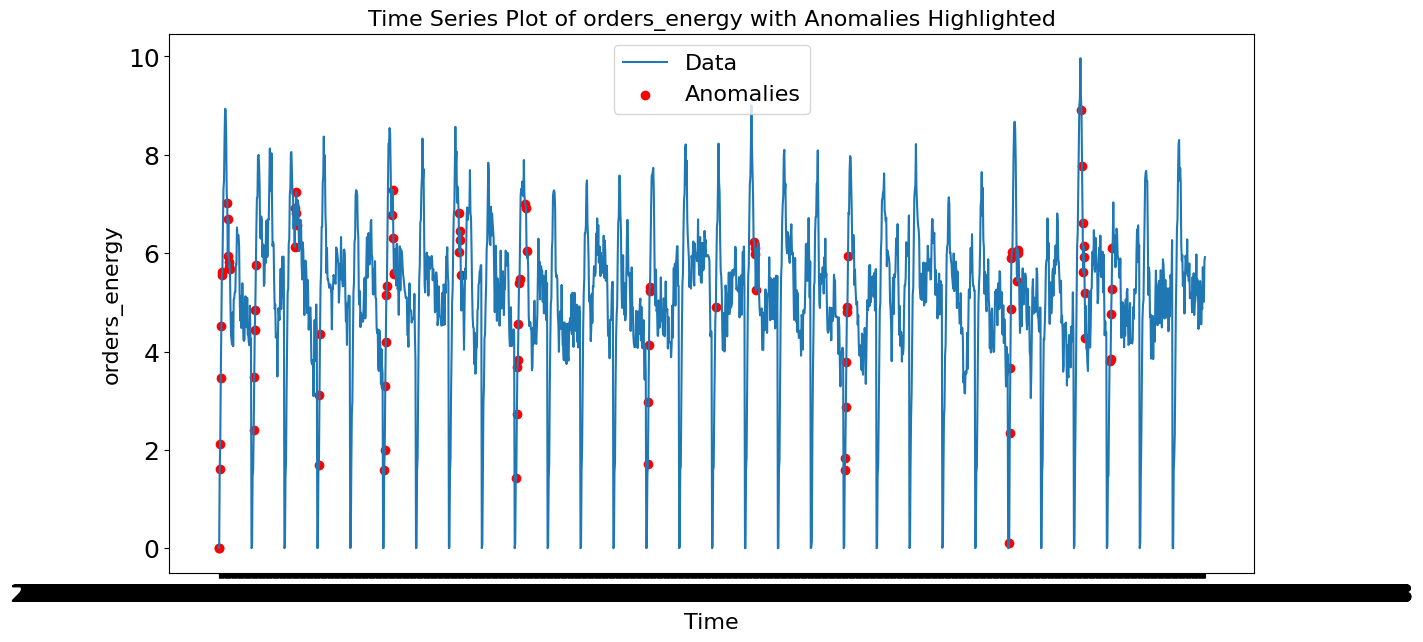

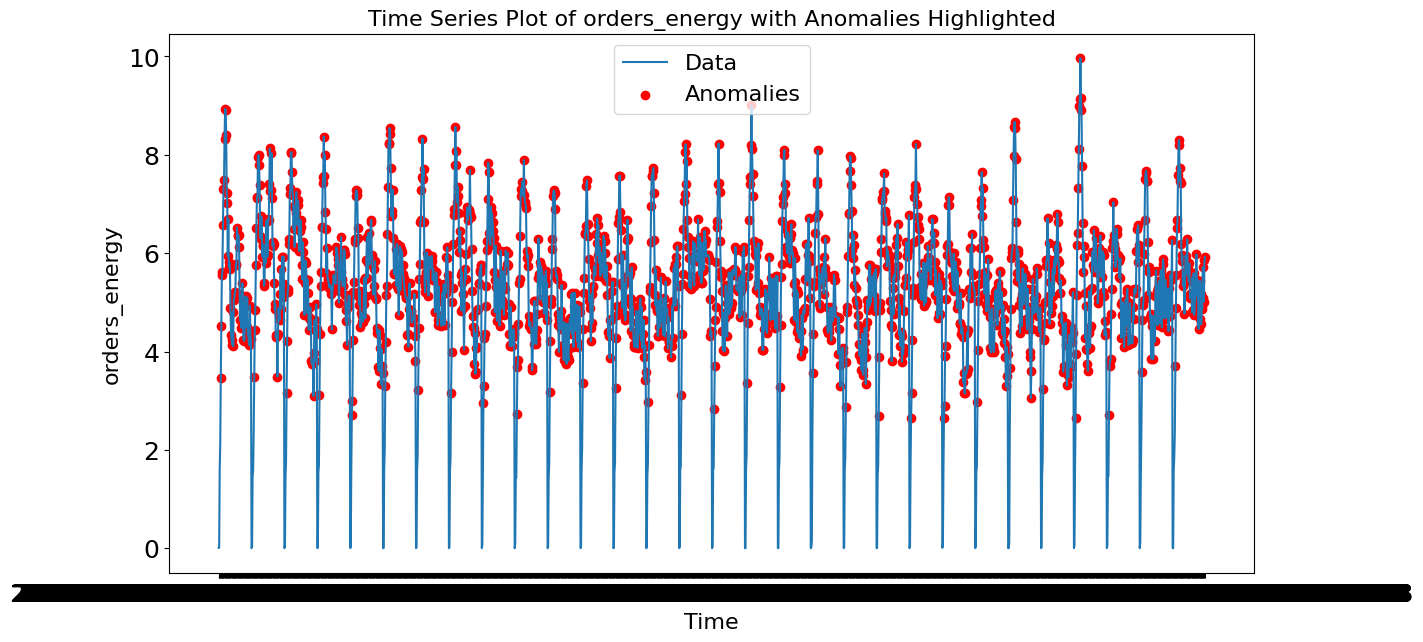

In [89]:
column_to_plot = 'orders_energy'  # Replace with the actual column name
anomaly_column = f"{column_to_plot}_Anomaly"
algo_results = Path(f"../AD/results/{SYSTEM}/scenario_B/orders/1000/BIRCH_results.csv")
algo_df = pd.read_csv(algo_results)

# Plot the time series data
plt.figure(figsize=(14, 7))
plt.plot(algo_df['time'], algo_df[column_to_plot], label='Data')

# Highlight anomalies
anomalies = algo_df[algo_df[anomaly_column] == 1]
plt.scatter(anomalies['time'], anomalies[column_to_plot], color='red', label='Anomalies')

plt.xlabel('Time')
plt.ylabel(column_to_plot)
plt.title(f'Time Series Plot of {column_to_plot} with Anomalies Highlighted')
plt.legend()
plt.show()

gt_df = pd.read_csv(GT_FOLDER)

    # Filter the ground truth for the specific scenario, service, and user
filtered_gt_df = gt_df[
    (gt_df['scenario'] == 'scenario_B') & 
    (gt_df['service'] == 'orders') & 
    (gt_df['users'] == int(1000))
]

# Plot the time series data
plt.figure(figsize=(14, 7))
plt.plot(filtered_gt_df['time'], filtered_gt_df[column_to_plot], label='Data')

# Highlight anomalies
anomalies = filtered_gt_df[filtered_gt_df[anomaly_column] == 1]
plt.scatter(anomalies['time'], anomalies[column_to_plot], color='red', label='Anomalies')

plt.xlabel('Time')
plt.ylabel(column_to_plot)
plt.title(f'Time Series Plot of {column_to_plot} with Anomalies Highlighted')
plt.legend()
plt.show()

In [194]:
def get_overall_AD_and_RCA_data():
    ad_stats = {}
    rca_stats = {}
    scenarios = get_folder_names(RCA_DATA_FOLDER)

    for scenario in scenarios:
        scenario_folder = os.path.join(RCA_DATA_FOLDER, scenario)
        services = get_folder_names(scenario_folder)

        for service in services:
            service_folder = os.path.join(scenario_folder, service)
            users = get_folder_names(service_folder)
            
            for user in users:
                user_folder = os.path.join(service_folder, user)
                trials = get_folder_names(user_folder)
                csv_files = [f for f in os.listdir(user_folder) if 'statistics' in f]

                for file in csv_files:
                    model_df = pd.read_csv(os.path.join(user_folder, file))
                    model = file.split('_')[0]

                    if model in AD_MODELS:  
                        if model not in ad_stats:
                            ad_stats[model] = {"Precision": [], "Recall": [], "F-Score": [], "Accuracy": []}

                        ad_stats[model]["Precision"].extend(model_df['precision'].values)
                        ad_stats[model]["Recall"].extend(model_df['recall'].values)
                        ad_stats[model]["F-Score"].extend(model_df['f1score'].values)
                        ad_stats[model]["Accuracy"].extend(model_df['accuracy'].values)
                
                for trial in trials:
                    rca_folder = os.path.join(RCA_DATA_FOLDER, scenario, service, user, trial)
                    rca_files = [f for f in os.listdir(rca_folder) if 'statistics' in f]
                    for file in rca_files:
                        model_df = pd.read_csv(os.path.join(rca_folder, file))
                        model = file.split('_')[0]

                        if model in RCA_MODELS:
                            if not model in rca_stats:
                                rca_stats[model] = {"level_1": [], "level_2": [], "level_3": []}
                            
                            precision_at_1 = model_df.loc[model_df['level'] == 'level_1', 'precision'].values[0]
                            precision_at_2 = model_df.loc[model_df['level'] == 'level_2', 'precision'].values[0]
                            precision_at_3 = model_df.loc[model_df['level'] == 'level_3', 'precision'].values[0]
                            
                            rca_stats[model]["level_1"].append(precision_at_1)
                            rca_stats[model]["level_2"].append(precision_at_2)
                            rca_stats[model]["level_3"].append(precision_at_3)

    return ad_stats, rca_stats


In [24]:
def export_ad_table(model, values, data_list):
  precision = values["Precision"]
  recall = values["Recall"]
  fscore = values["F-Score"]
  accuracy = values["Accuracy"]
                  
  precision = {
      'Algorithm': model,
      'Metric': 'Precision',
      'Min': np.min(precision),
      'Max': np.max(precision),
      'Median': round(np.median(precision), 3),
      'Mean': round(np.mean(precision), 3),
      'SD': round(np.std(precision), 3),
      'CV': round(np.cov(precision, rowvar=False).item(0), 3),
    }

  recall = {
      'Algorithm': model,
      'Metric': 'Recall',
      'Min': np.min(recall),
      'Max': np.max(recall),
      'Median': round(np.median(recall), 3),
      'Mean': round(np.mean(recall), 3),
      'SD': round(np.std(recall), 3),
      'CV': round(np.cov(recall, rowvar=False).item(0), 3),
  }

  fscore = {
      'Algorithm': model,
      'Metric': 'F-Score',
      'Min': np.min(fscore),
      'Max': np.max(fscore),
      'Median': round(np.median(fscore), 3),
      'Mean': round(np.mean(fscore), 3),
      'SD': round(np.std(fscore), 3),
      'CV': round(np.cov(fscore, rowvar=False).item(0), 3),
  }

  accuracy = {
      'Algorithm': model,
      'Metric': 'Accuracy',
      'Min': np.min(accuracy),
      'Max': np.max(accuracy),
      'Median': round(np.median(accuracy), 3),
      'Mean': round(np.mean(accuracy), 3),
      'SD': round(np.std(accuracy), 3),
      'CV': round(np.cov(accuracy, rowvar=False).item(0), 3),
  }

  data_list.extend([precision, recall, fscore, accuracy])
  return data_list

In [195]:
def export_rca_table(model, values, data_list):
  precision_level_1 = values["level_1"]
  precision_level_2 = values["level_2"]
  precision_level_3 = values["level_3"]
                
  average_precision_level_1 = np.mean(precision_level_1)
  average_precision_level_2 = np.mean(precision_level_2)
  average_precision_level_3 = np.mean(precision_level_3)
  
  mAP = np.mean([average_precision_level_1, average_precision_level_2, average_precision_level_3])
  precision_level_1_stats = {
      'Algorithm': model,
      'Precision Level': 'Precision@1',
      'Min': np.min(precision_level_1),
      'Max': np.max(precision_level_1),
      'Median': round(np.median(precision_level_1), 3),
      'Mean': round(np.mean(precision_level_1), 3),
      'SD': round(np.std(precision_level_1), 3),
      'CV': round(np.cov(precision_level_1, rowvar=False).item(0), 3),
      'MAP': round(mAP, 3)
  }

  precision_level_2_stats = {
      'Algorithm': model,
      'Precision Level': 'Precision@2',
      'Min': np.min(precision_level_2),
      'Max': np.max(precision_level_2),
      'Median': round(np.median(precision_level_2), 3),
      'Mean': round(np.mean(precision_level_2), 3),
      'SD': round(np.std(precision_level_2), 3),
      'CV': round(np.cov(precision_level_2, rowvar=False).item(0), 3),
      'MAP': round(mAP, 3)
  }

  precision_level_3_stats = {
      'Algorithm': model,
      'Precision Level': 'Precision@3',
      'Min': np.min(precision_level_3),
      'Max': np.max(precision_level_3),
      'Median': round(np.median(precision_level_3), 3),
      'Mean': round(np.mean(precision_level_3), 3),
      'SD': round(np.std(precision_level_3), 3),
      'CV': round(np.cov(precision_level_3, rowvar=False).item(0), 3),
      'MAP': round(mAP, 3)
  }

  data_list.extend([precision_level_1_stats, precision_level_2_stats, precision_level_3_stats])

              
  return data_list

In [196]:
def get_overall_stats():
  ad_stats = {}
  rca_stats = {}

  ad_stats, rca_stats = get_overall_AD_and_RCA_data()

  # data_list = []
  # for model, values in ad_stats.items():
  #   data_list = export_ad_table(model, values, data_list)

  rca_list = []
  for model, values in rca_stats.items():
    rca_list = export_rca_table(model, values, rca_list)

  # Create a DataFrame
  # ad_df = pd.DataFrame(data_list)
  rca_df = pd.DataFrame(rca_list)

  # Export to CSV
  # ad_folder = os.path.join(DESCRIPTIVE_STATISTICS_FOLDER, SYSTEM, 'AD')
  # os.makedirs(ad_folder, exist_ok=True)
  file_name = f'{SYSTEM}_OVERALL.csv'
  # ad_path = os.path.join(ad_folder, file_name)
  # ad_df.to_csv(ad_path, index=False)   

  rca_folder = os.path.join(DESCRIPTIVE_STATISTICS_FOLDER, SYSTEM, 'RCA')   
  os.makedirs(rca_folder, exist_ok=True)
  rca_path = os.path.join(rca_folder, file_name)
  rca_df.to_csv(rca_path, index=False)

In [203]:
get_overall_stats()

In [121]:
# def get_AD_and_RCA_data_per_treatment():
#   ad_stats = {}
#   scenarios = get_folder_names(DATA_FOLDER)

#   for scenario in scenarios:
#       scenario_folder = os.path.join(DATA_FOLDER, scenario)
#       services = get_folder_names(scenario_folder)

#       for service in services:
#           service_folder = os.path.join(scenario_folder, service)
#           users = get_folder_names(service_folder)
          
#           for user in users:
#               user_folder = os.path.join(service_folder, user)
#               csv_files = [f for f in os.listdir(user_folder) if 'statistics' in f]

#               for file in csv_files:
#                   model_df = pd.read_csv(os.path.join(user_folder, file))
#                   model = file.split('_')[0]

#                   if model in AD_MODELS:  
#                       if model not in ad_stats:
#                           ad_stats.setdefault(scenario, {}).setdefault(service, {}).setdefault(user, {}).setdefault(model, {"Precision": [], "Recall": [], "F-Score": []})

#                       ad_stats[scenario][service][user][model]["Precision"].extend(model_df['precision'].values)
#                       ad_stats[scenario][service][user][model]["Recall"].extend(model_df['recall'].values)
#                       ad_stats[scenario][service][user][model]["F-Score"].extend(model_df['f1score'].values)

#   return ad_stats


In [118]:
# def export_AD_metric_tables_by_treatment(ad_stats):
#   for scenario, scenario_dict in ad_stats.items():
#     for service, service_dict in scenario_dict.items():
#       for user, user_dict in service_dict.items():
#         for scenario, scenario_dict in user_dict.items():  
#           data_list = []

#           for model, values in user_dict.items():
#             print(f"\n Scenario {scenario} Service_stressed {service} User {user} Model {model} \n")
            
#             data_list = export_ad_table(model, values, data_list)

#           # Create a DataFrame
#           df = pd.DataFrame(data_list)

#           # Export to CSV
#           ad_folder = os.path.join(DESCRIPTIVE_STATISTICS_FOLDER, SYSTEM, 'AD')
#           os.makedirs(ad_folder, exist_ok=True)
#           file_name = f'{scenario}_{service}_{user}.csv'
#           path = os.path.join(ad_folder, file_name)
#           df.to_csv(path, index=False)

In [204]:
def get_detailed_AD_and_RCA_data():
    ad_stats = {}
    rca_stats = {}
    scenarios = get_folder_names(RCA_DATA_FOLDER)

    for scenario in scenarios:
        scenario_folder = os.path.join(RCA_DATA_FOLDER, scenario)
        services = get_folder_names(scenario_folder)

        for service in services:
            service_folder = os.path.join(scenario_folder, service)
            users = get_folder_names(service_folder)
            
            for user in users:
                user_folder = os.path.join(service_folder, user)
                csv_files = [f for f in os.listdir(user_folder) if 'statistics' in f]

                repetition_folder = os.path.join(RCA_DATA_FOLDER, scenario, service, user)
                trials = get_folder_names(repetition_folder)
                
                for file in csv_files:
                    model_df = pd.read_csv(os.path.join(user_folder, file))
                    model = file.split('_')[0]

                    if model in AD_MODELS:  
                        # Initialize dictionary if it does not exist
                        if model not in ad_stats:
                            ad_stats[model] = {}

                        # Use nested dictionary to store values per scenario, service, and user
                        if scenario not in ad_stats[model]:
                            ad_stats[model][scenario] = {}
                        if service not in ad_stats[model][scenario]:
                            ad_stats[model][scenario][service] = {}
                        if user not in ad_stats[model][scenario][service]:
                            ad_stats[model][scenario][service][user] = {
                                "Precision": [],
                                "Recall": [],
                                "F-Score": [],
                                "Accuracy": []
                            }

                        # Add statistics to respective lists
                        ad_stats[model][scenario][service][user]["Precision"].extend(model_df['precision'].values)
                        ad_stats[model][scenario][service][user]["Recall"].extend(model_df['recall'].values)
                        ad_stats[model][scenario][service][user]["F-Score"].extend(model_df['f1score'].values)
                        ad_stats[model][scenario][service][user]["Accuracy"].extend(model_df['accuracy'].values)
                for trial in trials:
                    rca_folder = os.path.join(repetition_folder, trial)
                    rca_files = [f for f in os.listdir(rca_folder) if 'statistics' in f]
                    for file in rca_files:
                        model_df = pd.read_csv(os.path.join(rca_folder, file))
                        model = file.split('_')[0]

                        if model in RCA_MODELS:
                            if not model in rca_stats:
                                rca_stats[model] = {}
                            # Use nested dictionary to store values per scenario, service, and user
                            if scenario not in rca_stats[model]:
                                rca_stats[model][scenario] = {}
                            if service not in rca_stats[model][scenario]:
                                rca_stats[model][scenario][service] = {}
                            if user not in rca_stats[model][scenario][service]:
                                rca_stats[model][scenario][service][user] = {
                                    "level_1": [],
                                    "level_2": [],
                                    "level_3": []
                                }
                            
                            precision_at_1 = model_df.loc[model_df['level'] == 'level_1', 'precision'].values[0]
                            precision_at_2 = model_df.loc[model_df['level'] == 'level_2', 'precision'].values[0]
                            precision_at_3 = model_df.loc[model_df['level'] == 'level_3', 'precision'].values[0]
                            
                            rca_stats[model][scenario][service][user]["level_1"].append(precision_at_1)
                            rca_stats[model][scenario][service][user]["level_2"].append(precision_at_2)
                            rca_stats[model][scenario][service][user]["level_3"].append(precision_at_3)

    return ad_stats, rca_stats

def export_detailed_ad_table(ad_stats):
    data_list = []

    # Iterate over models, scenarios, services, and users to calculate mean metrics
    for model, scenarios_dict in ad_stats.items():
        for scenario, services_dict in scenarios_dict.items():
            for service, users_dict in services_dict.items():
                for user, metrics in users_dict.items():
                    # Calculate mean values for each metric
                    precision_mean = round(np.mean(metrics["Precision"]), 3)
                    recall_mean = round(np.mean(metrics["Recall"]), 3)
                    fscore_mean = round(np.mean(metrics["F-Score"]), 3)
                    accuracy_mean = round(np.mean(metrics["Accuracy"]), 3)

                    # Append to data list
                    data_list.append({
                        'Model': model,
                        'Scenario': scenario,
                        'Service': service,
                        'Users': user,
                        'Mean Precision': precision_mean,
                        'Mean Recall': recall_mean,
                        'Mean F-Score': fscore_mean,
                        'Mean Accuracy': accuracy_mean,
                    })

    # Convert to DataFrame and save to CSV
    df = pd.DataFrame(data_list)
    detailed_folder = os.path.join(DESCRIPTIVE_STATISTICS_FOLDER, SYSTEM, 'AD')
    os.makedirs(detailed_folder, exist_ok=True)
    df.to_csv(os.path.join(detailed_folder, f'{SYSTEM}_detailed_AD_results.csv'), index=False)

def export_detailed_rca_table(ad_stats):
    data_list = []

    # Iterate over models, scenarios, services, and users to calculate mean metrics
    for model, scenarios_dict in ad_stats.items():
        for scenario, services_dict in scenarios_dict.items():
            for service, users_dict in services_dict.items():
                for user, metrics in users_dict.items():
                    # Calculate mean values for each metric
                    precision_level_1 = metrics["level_1"]
                    precision_level_2 = metrics["level_2"]
                    precision_level_3 = metrics["level_3"]
                                    
                    average_precision_level_1 = round(np.mean(precision_level_1), 3)
                    average_precision_level_2 = round(np.mean(precision_level_2), 3)
                    average_precision_level_3 = round(np.mean(precision_level_3), 3)
  
                    mAP = np.mean([average_precision_level_1, average_precision_level_2, average_precision_level_3])

                    # Append to data list
                    data_list.append({
                        'Model': model,
                        'Scenario': scenario,
                        'Service': service,
                        'Users': user,
                        'Mean Precision@1': average_precision_level_1,
                        'Mean Precision@2': average_precision_level_2,
                        'Mean Precision@3': average_precision_level_3
                    })

    # Convert to DataFrame and save to CSV
    df = pd.DataFrame(data_list)
    detailed_folder = os.path.join(DESCRIPTIVE_STATISTICS_FOLDER, SYSTEM, 'RCA')
    os.makedirs(detailed_folder, exist_ok=True)
    df.to_csv(os.path.join(detailed_folder, f'{SYSTEM}_detailed_RCA_results.csv'), index=False)

# Run the functions
ad_stats, rca_stats = get_detailed_AD_and_RCA_data()
# export_detailed_ad_table(ad_stats)
export_detailed_rca_table(rca_stats)


Saved plot to Descriptive statistics\trainticket\RCA\plots\Mean_Precision@1_heatmap.png


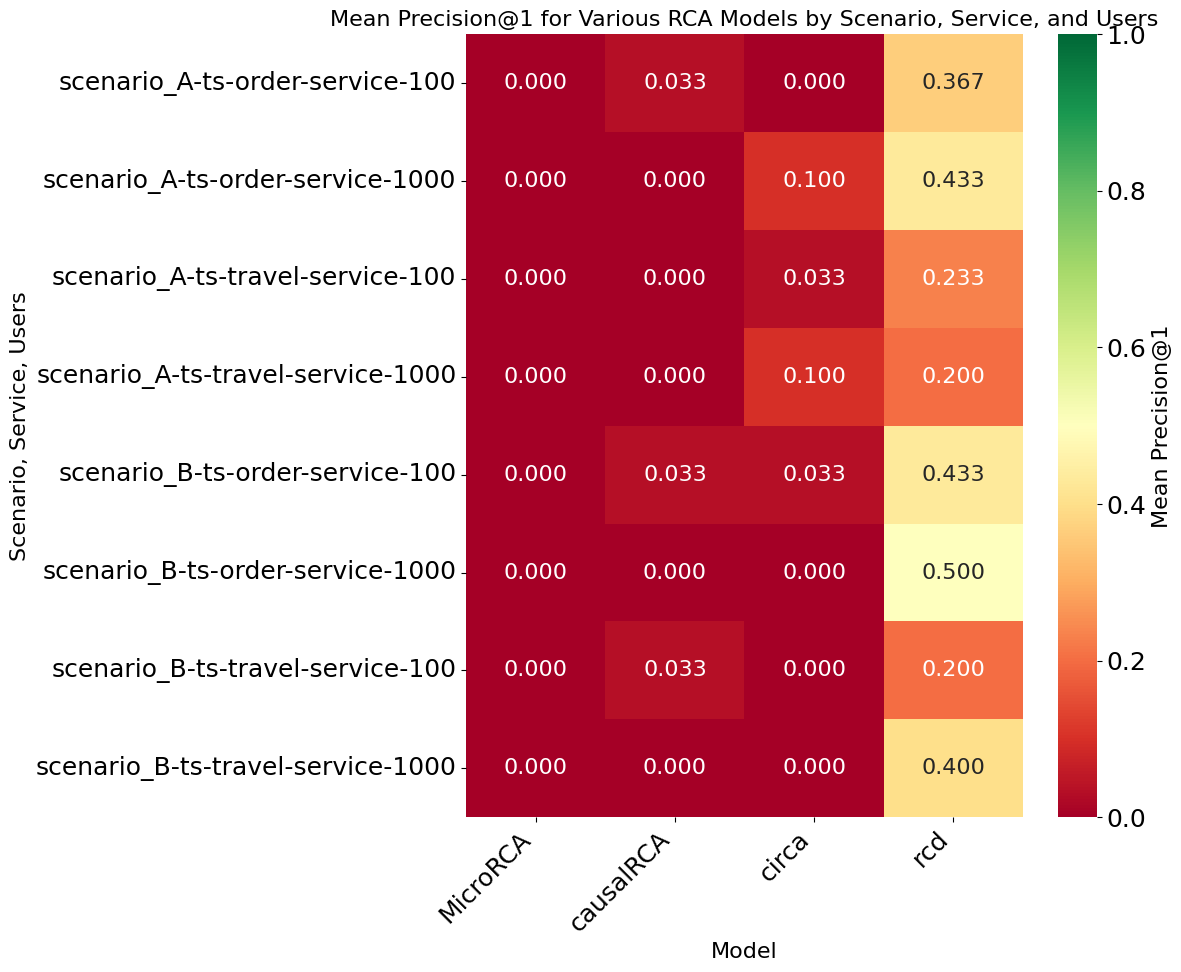

Saved plot to Descriptive statistics\trainticket\RCA\plots\Mean_Precision@2_heatmap.png


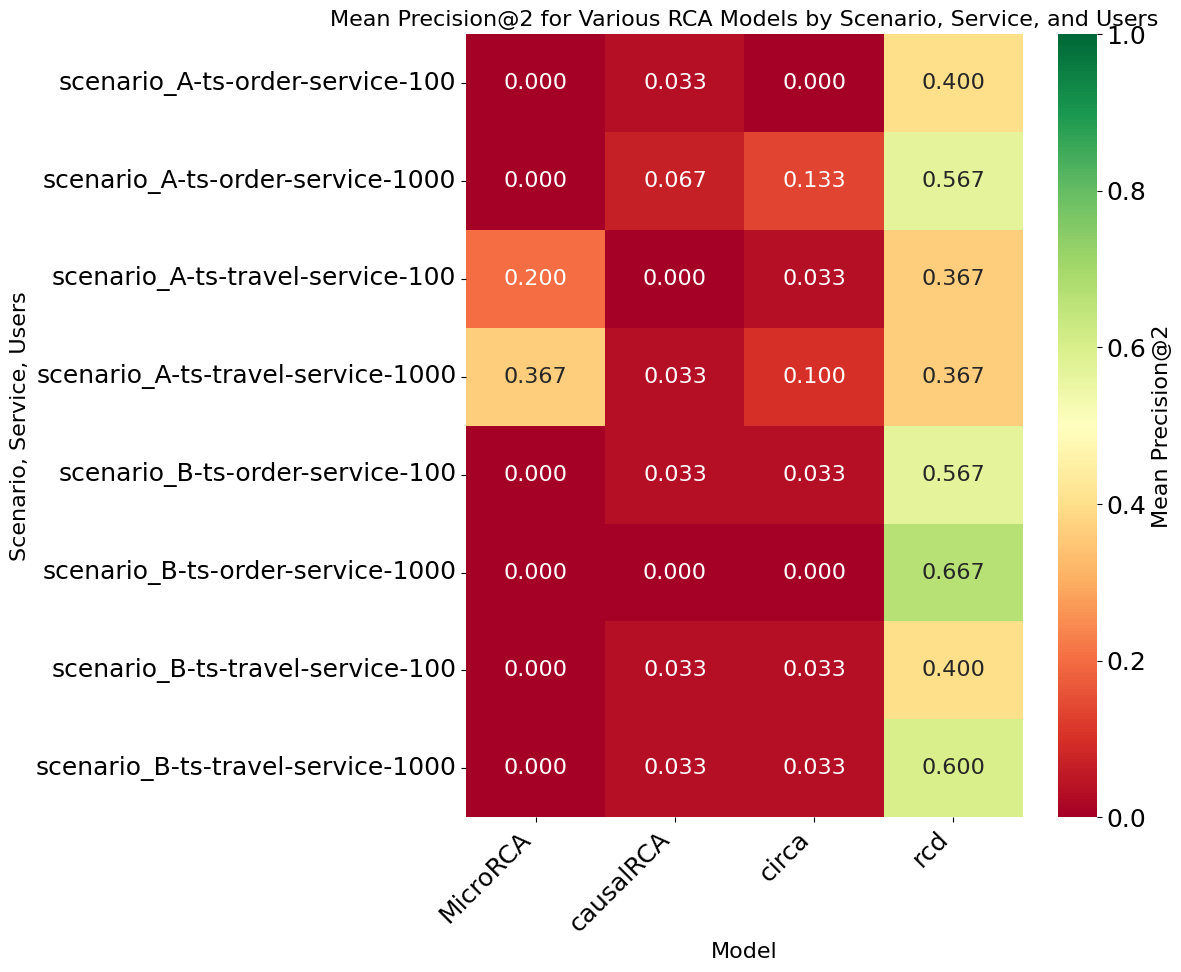

Saved plot to Descriptive statistics\trainticket\RCA\plots\Mean_Precision@3_heatmap.png


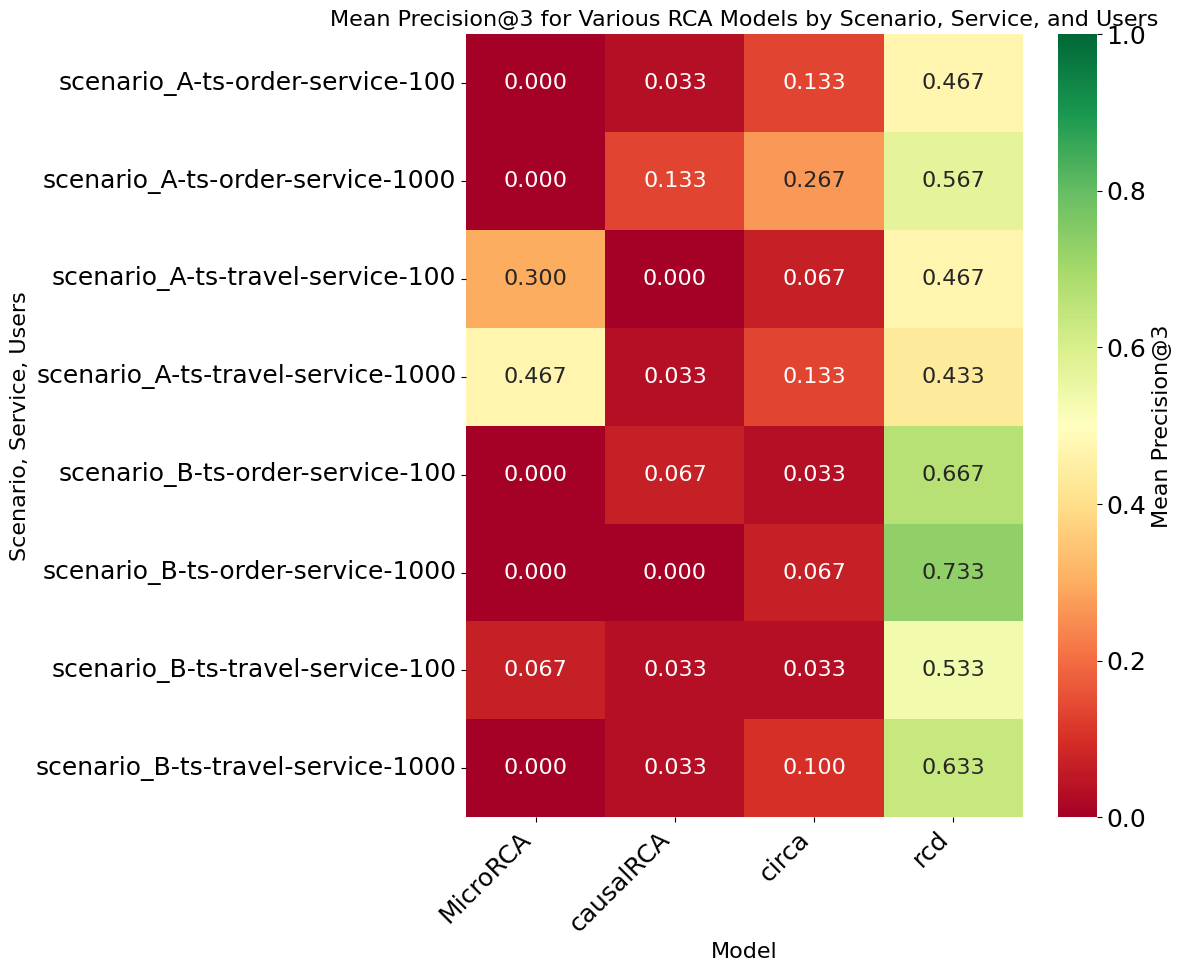

In [205]:
def plot_metric_heatmap(folder, system, metric, algo_type):
    # Load the data
    data = pd.read_csv(os.path.join(folder, f'{system}_detailed_{algo_type}_results.csv'))

    # Create a new column combining Scenario, Service, and Users
    data['Scenario_Service_Users'] = data['Scenario'] + '-' + data['Service'] + '-' + data['Users'].astype(str)

    # Pivot the data to create a matrix for the specified metric
    pivot_data = data.pivot(index="Scenario_Service_Users", columns="Model", values=metric)

    # Plotting the heatmap with seaborn
    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot_data, annot=True, fmt=".3f", cmap="RdYlGn", cbar_kws={'label': metric}, vmin=0, vmax=1)

    plt.title(f"{metric} for Various {algo_type} Models by Scenario, Service, and Users")
    plt.xlabel("Model")
    plt.ylabel("Scenario, Service, Users")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # plt.show()

    output_folder = os.path.join(folder, "plots")
    os.makedirs(output_folder, exist_ok=True)
    
    file_path = os.path.join(output_folder, f"{metric.replace(' ', '_')}_heatmap.png")
    plt.savefig(file_path, dpi=300)
    print(f"Saved plot to {file_path}")
    plt.show()
    plt.close()


folder = os.path.join(DESCRIPTIVE_STATISTICS_FOLDER, SYSTEM, 'AD')
# plot_metric_heatmap(folder, SYSTEM, "Mean Precision", "AD")
# plot_metric_heatmap(folder, SYSTEM, "Mean Recall", "AD")
# plot_metric_heatmap(folder, SYSTEM, "Mean F-Score", "AD")
# plot_metric_heatmap(folder, SYSTEM, "Mean Accuracy", "AD")
rca_folder = os.path.join(DESCRIPTIVE_STATISTICS_FOLDER, SYSTEM, 'RCA')
plot_metric_heatmap(rca_folder, SYSTEM, "Mean Precision@1", "RCA")
plot_metric_heatmap(rca_folder, SYSTEM, "Mean Precision@2", "RCA")
plot_metric_heatmap(rca_folder, SYSTEM, "Mean Precision@3", "RCA")
